# Additional figure creation

In this notebook we provide the code to generate the figures for:
* Example Pareto front/set (Fig 1.)
* Acquisition function contours (Fig 2.)
* Weighted EI contours (Fig 3.) 
* Landscape of the WangFreitas test problem (Supplementary material, Fig 1.)

In [1]:
import GPy
import scipy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#preamble to use latex to render the images with 
# the libertine font for use in acm-small
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}',
                                       r'\usepackage[libertine]{newtxmath}',
                                       r'\usepackage{sfmath}',
                                       r'\usepackage[T1]{fontenc}'
                                      ]

save_figs = False  # True to actually save pdfs

# Example Pareto front (Fig 1.)

In [2]:
def phi(x):
    return scipy.stats.norm.pdf(x)

def Phi(x):
    return scipy.stats.norm.cdf(x)

def EI(mu, sigma, f_best=0, omega=0.5):
    s = (mu - f_best) / sigma
    return sigma * (s * Phi(s) * omega + (1 - omega) * phi(s))

def PI(mu, sigma, f_best=0):
    s = (mu - f_best) / sigma
    return Phi(s)

def UCB(mu, sigma, beta=2):
    return mu + beta*sigma

def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = np.zeros(X.shape[0], dtype=int)
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = np.min(np.sum(X >= X[n,:], 1)) > 0

    return np.array(y, dtype='bool')

def target(x):
    """
    Function to optimise
    """
    f = np.sin( 3 * np.pi * x**3) - 0.5 * np.sin(8 * np.pi * x**3)
    f /= 2
    return f

In [3]:
# training points
X = [0.1,  0.5,  0.75, 0.2, 0.59]
X = np.atleast_2d(np.asarray(X)).T
f = target(X)

# create GPy model
D = 1
kernel = GPy.kern.Matern52(D) #+ GPy.kern.White(D)
m = GPy.models.GPRegression(X, f, kernel, normalizer=True)

# gpyopt settings
m.constrain_positive('')
kern_noise, kern_lengthscale, gaussian_noise = m.parameter_names()
m[kern_noise].constrain_bounded(1e-6, 1e6, warning=False)
m[kern_lengthscale].constrain_bounded(1e-6, 1e6, warning=False)
m[gaussian_noise].constrain_fixed(1e-6, warning=False)

# use specific kernel hyperparameters for reproducability
m[kern_lengthscale] = 0.1
m[kern_noise] = 2

# predict the mean and variance along [0, 1]
x = np.linspace(0, 1, 200)
mu, var = [_.ravel() for _ in m.predict(np.atleast_2d(x).T)]
sigma = np.sqrt(var)

# create mask of non-dominate values (i.e. those on the Pareto front)
pf_mask = notDominated(-np.vstack((mu, sigma)).T).astype('bool')

# calculate which points maximise EI, UCB, and PI
max_EI_idx = np.argmax(EI(mu, sigma, f_best=np.max(f)))
max_PI_idx = np.argmax(PI(mu, sigma, f_best=np.max(f)))
max_UCB_idx = np.argmax(UCB(mu, sigma))

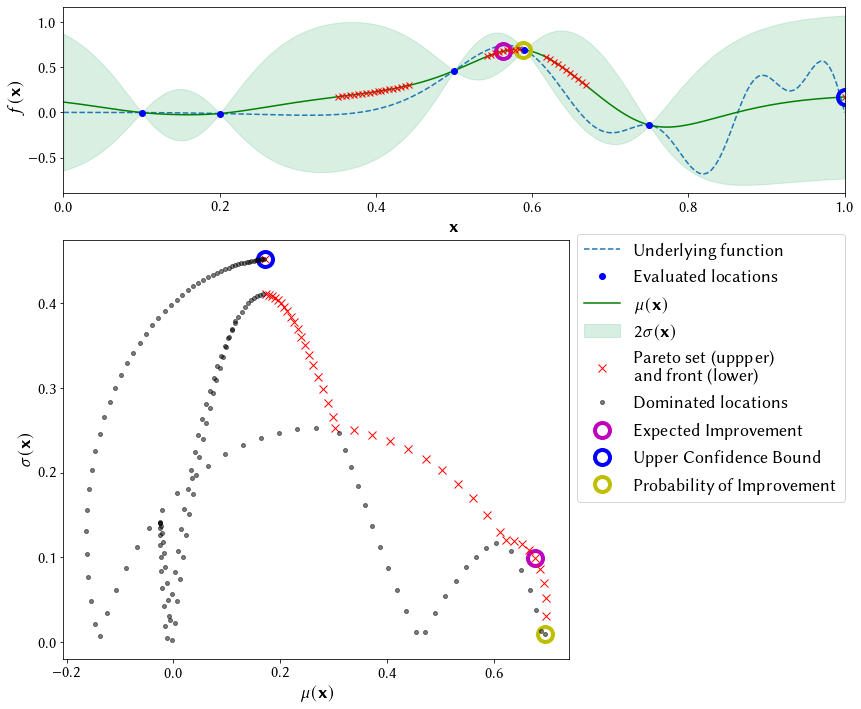

In [4]:
label_fontsize = 18
tick_fontsize = 16
legend_fontsize = 18

ax = []
fig = plt.figure(constrained_layout=False, figsize=(14, 12))
gs = fig.add_gridspec(3, 3)
ax.append(fig.add_subplot(gs[0, :]))
ax.append(fig.add_subplot(gs[1:,:2]))

# top image: surrogate model with pareto front highlighted
ax[0].plot(x, target(x), '--', label='Underlying function')
ax[0].plot(x, mu, 'green', label='$\mu(\mathbf{x})$')
ax[0].fill_between(x, mu + 2*sigma, mu - 2*sigma, color='mediumseagreen', alpha=0.2, label='$2\sigma(\mathbf{x})$')
ax[0].plot(X, f, 'bo', label='Evaluated locations')
ax[0].plot(x[max_EI_idx], mu[max_EI_idx], 'mo', markerfacecolor='none', mew=4, ms=15)
ax[0].plot(x[max_PI_idx], mu[max_PI_idx], 'yo', markerfacecolor='none', mew=4, ms=15)
ax[0].plot(x[max_UCB_idx], mu[max_UCB_idx], 'bo', markerfacecolor='none', mew=4, ms=15)
ax[0].plot(x[pf_mask], mu[pf_mask], 'rx')

ax[0].set_xlim(min(x), max(x))
ax[0].set_xlabel('$\mathbf{x}$', fontsize=label_fontsize)
ax[0].set_ylabel('$f(\mathbf{x})$', fontsize=label_fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)

# lower image: all mu,sigma pairs and the pareto front highlighted
ax[1].plot(mu[max_EI_idx], sigma[max_EI_idx], 'mo', markerfacecolor='none', mew=4, ms=15, label='Expected Improvement')
ax[1].plot(mu[max_UCB_idx], sigma[max_UCB_idx], 'bo', markerfacecolor='none', mew=4, ms=15, label='Upper Confidence Bound')
ax[1].plot(mu[max_PI_idx], sigma[max_PI_idx], 'yo', markerfacecolor='none', mew=4, ms=15, label='Probability of Improvement')

ax[1].plot(mu[pf_mask], sigma[pf_mask], 'rx', ms=8, label='Pareto set (uppper)\nand front (lower)')
ax[1].plot(mu[~pf_mask], sigma[~pf_mask], 'k.', alpha=0.5, ms=8, label='Dominated locations')

ax[1].set_xlabel('$\mu(\mathbf{x})$', fontsize=label_fontsize)
ax[1].set_ylabel('$\sigma(\mathbf{x})$', fontsize=label_fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

# rearrange legend order
ax0_order = [0, 2, 1, 3]
handles0, labels0 = ax[0].get_legend_handles_labels()
handles0 = np.array(handles0)[ax0_order].tolist()
labels0 = np.array(labels0)[ax0_order].tolist()

ax1_order = [3, 4, 0, 1, 2]
handles1, labels1 = ax[1].get_legend_handles_labels()
handles1 = np.array(handles1)[ax1_order].tolist()
labels1 = np.array(labels1)[ax1_order].tolist()
    
fig.legend(handles=handles0+handles1, labels=labels0+labels1,    
           loc='center left', 
           fontsize=legend_fontsize,
           bbox_to_anchor=(0.563, 0.395)
           )

if save_figs:
    plt.savefig('pareto-front-example.pdf', bbox_inches='tight')
plt.show()

The above plot shows:

* Top: Gaussian Process approximation to a function (blue dashed curve) resulting from the 5 observations shown; mean $\mu(x)$ is shown in dark green and twice the posterior standard deviation $\sigma(x)$ is shown as the light green envelopes. 
    
* Bottom: 200 samples uniformly spaced in X plotted in $\mu, \sigma$ space.

The non-dominated locations forming the Pareto front are shown in red and their locations marked above. Locations maximising the Expected Improvement, Upper Confidence Bound and Probability of Improvement acquisition functions are marked in both plots.

# Acquisition function contours (Fig 2.)

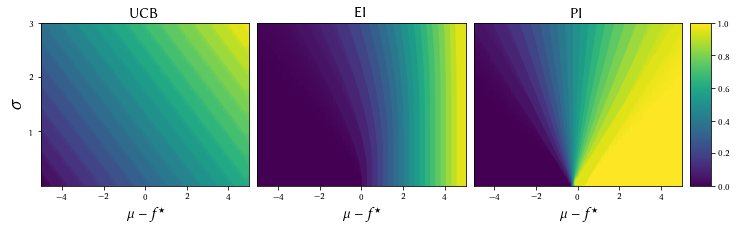

In [5]:
# Range of mu and sigma to evaluate the grid over
sigma = np.linspace(1e-7, 3, 50)
mu = np.linspace(-5, 5, 50)

M, S = np.meshgrid(mu, sigma)
ms = np.column_stack((M.ravel(), S.ravel()))

fig, axx = plt.subplots(1, 4, figsize=(12, 3), 
                       gridspec_kw ={'width_ratios':[10,10,10,1]} )

for ax, f in zip(axx, [UCB, EI, PI]):
    # evaluate each acquisition function over the grid of mu and sigma values
    F = f(*ms.T)
    F = np.asarray(F).reshape(len(sigma), len(mu))
    
    # rescale results to [0, 1]
    F = (F-F.min())/(F.max()-F.min())
    
    # create the plot
    h = ax.pcolor(mu, sigma, F, rasterized=True, vmin=0, vmax=1)
    ax.contour(mu, sigma, F, 20, linewidths=10)
    ax.set_title(f.__name__, fontsize=15)
    ax.set_xlabel('$\mu - f^\star$', size=15)
    
    # set y-axis label and ticks only on the left-most plot
    if ax == axx[0]:
        ax.set_ylabel('$\sigma$', size=20)
        ax.set_yticks([1, 2, 3])
    else:
        ax.set_yticks([])

# add a colourbar and adjust the spacing between figures
plt.colorbar(h, cax=axx[-1], orientation='vertical')
plt.subplots_adjust(left=None, bottom=None, 
                    right=None, top=None, 
                    wspace=0.05, hspace=None)

if save_figs:
    savefig('infill-contours.pdf', bbox_inches='tight')
plt.show()

The above figure shows the contours of upper confidence bound (UCB, $\beta$ = 1), expected improvement (EI) and probability of improvement (PI) as functions of predicted mean $\mu(x)$ and uncertainty $\sigma(x)$. Since the scale of the acquisitoin functions are immaterial, all three infill criteria have been mapped to $[0,1]$.

# Weighted EI contours (Fig 3.)

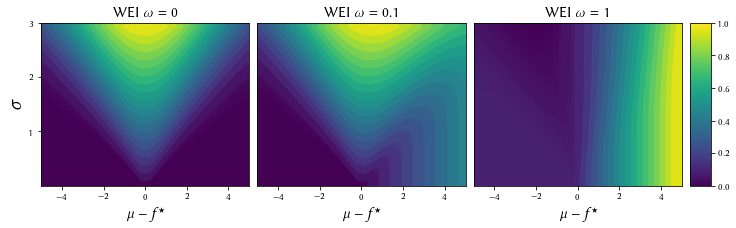

In [6]:
fig, axx = plt.subplots(1, 4, figsize=(12, 3), 
                       gridspec_kw ={'width_ratios':[10,10,10,1]} )

for ax, omega in zip(axx, [0.0, 0.1, 1]):
    # evaluate EI over the grid of mu and sigma values
    F = EI(*ms.T, f_best=0, omega=omega)
    F = np.asarray(F).reshape(len(sigma), len(mu))
    
    # rescale results to [0, 1]
    F = (F-F.min())/(F.max()-F.min())
    
    # create the plot
    h = ax.pcolor(mu, sigma, F, rasterized=True, vmin=0, vmax=1)
    ax.contour(mu, sigma, F, 20, linewidths=10)
    ax.set_title("WEI     $\omega = %g$" % omega, fontsize=15)
    ax.set_xlabel('$\mu - f^\star$', size=15)
    
    # set y-axis label and ticks only on the left-most plot
    if ax == axx[0]:
        ax.set_ylabel('$\sigma$', size=20)
        ax.set_yticks([1, 2, 3])
    else:
        ax.set_yticks([])


fig.colorbar(h, cax=axx[-1], orientation='vertical');
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)

if save_figs:
    savefig('EI-contours.pdf', bbox_inches='tight')

EI can be written as a weighted sum of two components:

\begin{equation}
\alpha_{WEI}(\mathbf{x}, \omega) = \sigma(\mathbf{x})
\left[ \omega s \Phi(s) + (1-\omega)\phi(s)\right]
\end{equation}

where $s = \frac{\mu(\mathbf{x}) - f^\star}{\sigma(\mathbf{x})}$
and $0 \leq \omega \leq 1$ and $\omega = \tfrac{1}{2}$ recovers the original EI formulation.

The above figure shows the contours of weighted expected improvement as functions of the surrogate model’s predicted mean $\mu(x)$ and uncertainty $\sigma(x)$ for weights $\omega \in \{0, 0.1, 1\}$. In none of these cases is the $x'$ maximising $\alpha_{WEI}(x′, \omega)$ guaranteed to lie in the Pareto set of maximally exploratory and exploitative solutions.

# Landscape of the WangFreitas test problem (Supplementary material, Fig 1.)

In [7]:
def WangFreitas(x):
    x = np.atleast_2d(x)
    
    x_1 = 0.1
    x_2 = 0.9
    theta_1 = 0.1
    theta_2 = 0.01
    epsilon = 0
    
    part_1 = 2 * np.exp(-0.5 * (x_1 - x)**2 / theta_1**2)
    part_2 = 4 * np.exp(-0.5 * (x_2 - x)**2 / theta_2**2)
    
    return part_1 + part_2

In [8]:
# real function
x = np.linspace(0, 1, 1000)[:, None]
f = WangFreitas(x)

# training data
Xtr = np.linspace(0, 1, 6)[:, None]
Ytr = WangFreitas(Xtr)

# build gp model on training data
kernel = GPy.kern.Matern52(1)
m = GPy.models.GPRegression(Xtr, Ytr, kernel)
m.constrain_positive('')
kern_noise, kern_lengthscale, gaussian_noise = m.parameter_names()
m[gaussian_noise].constrain_fixed(1e-6, warning=False)

# optimise hyper-parameters
m.optimize_restarts(num_restarts=10, verbose=False)

# predict mean function and variance
yp, C = [_.ravel() for _ in m.predict(x)]

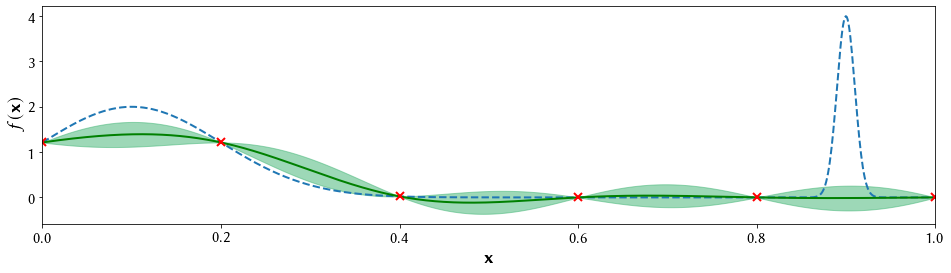

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(x, f, '--', lw=2)
ax.fill_between(x.ravel(), yp + 2*np.sqrt(C), yp - 2*np.sqrt(C), 
                color='mediumseagreen', alpha=0.5)
ax.plot(x, yp, 'green', lw=2)

ax.plot(Xtr, Ytr, 'rx', markersize=8, markeredgewidth=2)

ax.set_xlabel('$\mathbf{x}$', fontsize=label_fontsize)
ax.set_ylabel('$f(\mathbf{x})$', fontsize=label_fontsize)
ax.set_xlim([0, 1])
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

if save_figs:
    plt.savefig('WangFreitas-predict.pdf', bbox_inches='tight')
plt.show()

The WangFreitas test problem. The blue line shows the true function, the green solid line shows the mean prediction of a GP model trained on the red crosses, and the green areas depict the uncertainty (twice the standard deviation).